In [1]:
import logging
import os
import pdb
from pathlib import Path

import pandas as pd
import seaborn as sns
import xarray
from scipy.ndimage import maximum_filter

from contingency_table import accuracy, csi, ets, hk, hss, pod, pofd, total
from hwt import mpas, fv3

sns.set_theme()  # nice background on plots
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(message)s", force=True)
tmpdir = Path(os.getenv("TMPDIR"))

In [2]:
# Multiple thresholds for updraft helicity
# This is an older script that uses old save files that didn't
# use same helicityThresholds as defined in hwt module.
helicityThresholds = pd.Series(
    [1, 2, 5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200], name="thresh"
)
lead_time_days = range(5)

models = [fv3, mpas]
for model in models:
    model.group = "uh"

# assert models all have same number of variables
nvars = len(models[0].v)
assert all(
    [len(model.v) == nvars for model in models]
), "model objects have different number of variables to analyze"

conus_mask = xarray.open_dataarray(
    Path(os.getenv("HOME").replace(os.getenv("USER"), "ahijevyc")) / "HWT_2024.conus.nc"
)

rpt_types = ["torn", "wind", "hail"]
counts = ["hits", "misses", "false alarms", "correct nulls"]
filter_size = 3

In [3]:
mpas.v

['updraft_helicity_max01', 'updraft_helicity_max03', 'updraft_helicity_max']

In [4]:
# Replace USER with "ahijevyc". So it works for other users, like La Ditra.
datadir = Path(os.getenv("TMPDIR").replace(os.getenv("USER"), "ahijevyc"))
ofile = (
    datadir / f"hmfn.{len(helicityThresholds)}.{lead_time_days.stop}.{nvars}.{filter_size}.nc"
)

if os.path.exists(ofile):
    logging.info(f"read existing {ofile}")
    contingency_table = xarray.open_dataarray(ofile)
    # assert coordinates are what we expect
    assert (
        contingency_table["thresh"]
        .to_series()
        .reset_index(drop=True)
        .equals(helicityThresholds)
    ), f"unexpected helicityThresholds {contingency_table.thresh}"
    assert all(
        contingency_table["count"] == counts
    ), f"expected report types {counts}; got {contingency_table['count']}"
    assert all(
        contingency_table["model"] == [str(m) for m in models]
    ), f"expected report types {models}; got {contingency_table['model']}"
    assert (
        contingency_table["variable"].size == nvars
    ), f"expected {nvars} variables; got {contingency_table.variable}"
    assert all(
        contingency_table["rpt_type"].values == rpt_types
    ), f"expected report types {rpt_types}; got {contingency_table['rpt_types']}"
    assert (
        contingency_table["dayForecast"].size == lead_time_days.stop
    ), f"expected {lead_time_days.stop} dayForecasts; got {contingency_table['dayForecast'].size}"
else:
    logging.warning(f"create new {ofile}")
    contingency_table = xarray.DataArray(
        dims=["thresh", "count", "model", "rpt_type", "variable", "dayForecast"],
        coords={
            "thresh": helicityThresholds,
            "count": counts,
            "model": models,
            "rpt_type": rpt_types,
            "variable": range(nvars),
            "dayForecast": range(1, lead_time_days.stop + 1),
        },
    )
    # initialize to zero
    contingency_table[:] = 0

    start = pd.to_datetime("20240420") + pd.to_timedelta(lead_time_days.stop, unit="day")
    for valid_date in pd.date_range(start=start, end="20240531", freq="1D"):
        rptfile = datadir / f"near_rpt.{valid_date}.nc"
        if os.path.exists(rptfile):
            logging.info(f"open existing {rptfile}")
            near_rpts = xarray.open_dataarray(rptfile)
        else:
            logging.warning(f"no {rptfile}")
            continue
        for model in models:
            idir = Path(f"/glade/campaign/mmm/parc/schwartz/HWT2024/{model}")
            ncfile = datadir / f"forecast_yes.{model}.{valid_date}.{lead_time_days.stop}.nc"
            if os.path.exists(ncfile):
                logging.info(f"open existing {ncfile}")
                fo = xarray.open_dataset(ncfile)
                logging.info(model.v)
                fy = fo["fy"]
            else:
                logging.warning(f"no {ncfile}")
                continue

            # Assign generic variable names (0, 1, 2) instead of model-dependent names.
            fy = fy.assign_coords({"variable": contingency_table.coords["variable"]})
            logging.info(f"size-{filter_size} filter")
            londim = fy.dims.index("lon")
            latdim = fy.dims.index("lat")
            smoothfy = maximum_filter(fy, size=filter_size, axes=(londim, latdim))
            fy = xarray.DataArray(smoothfy, dims=fy.dims, coords=fy.coords, attrs=fy.attrs)

            # Keep near_rpts where conus_mask is True; otherwise set to nan.
            # nans will propagate to h, m, f, and n and not be counted when the .sum() function
            # is used below.
            near_rpts = near_rpts.where(conus_mask)
            h = fy * (near_rpts == 1)
            m = ~fy * (near_rpts == 1)
            f = fy * (near_rpts == 0)
            n = ~fy * (near_rpts == 0)

            contingency_table.loc[dict(count="hits", model=model)] += h.sum(dim=["lat", "lon"])
            contingency_table.loc[dict(count="misses", model=model)] += m.sum(
                dim=["lat", "lon"]
            )
            contingency_table.loc[dict(count="false alarms", model=model)] += f.sum(
                dim=["lat", "lon"]
            )
            contingency_table.loc[dict(count="correct nulls", model=model)] += n.sum(
                dim=["lat", "lon"]
            )

    # Can't save Model objects as netCDF. Convert to a simple string.
    contingency_table["model"] = contingency_table["model"].astype(str)

    contingency_table.to_netcdf(ofile)
    logging.warning(ofile)
contingency_table["thresh"].attrs["units"] = "$m^2/s^2$"

2024-09-23 14:47:34,530 read existing /glade/derecho/scratch/ahijevyc/tmp/hmfn.14.5.3.3.nc


In [5]:
contingency_table

<xarray.DataArray (thresh: 14, count: 4, model: 2, rpt_type: 3, variable: 3,
                   dayForecast: 5)>
[5040 values with dtype=float64]
Coordinates:
  * thresh       (thresh) int64 1 2 5 10 20 30 40 50 75 100 125 150 175 200
  * count        (count) <U13 'hits' 'misses' 'false alarms' 'correct nulls'
  * rpt_type     (rpt_type) <U4 'torn' 'wind' 'hail'
  * variable     (variable) int64 0 1 2
  * dayForecast  (dayForecast) int64 1 2 3 4 5
  * model        (model) <U4 'fv3' 'mpas'

In [6]:
assert total(contingency_table).max() == total(contingency_table).min()

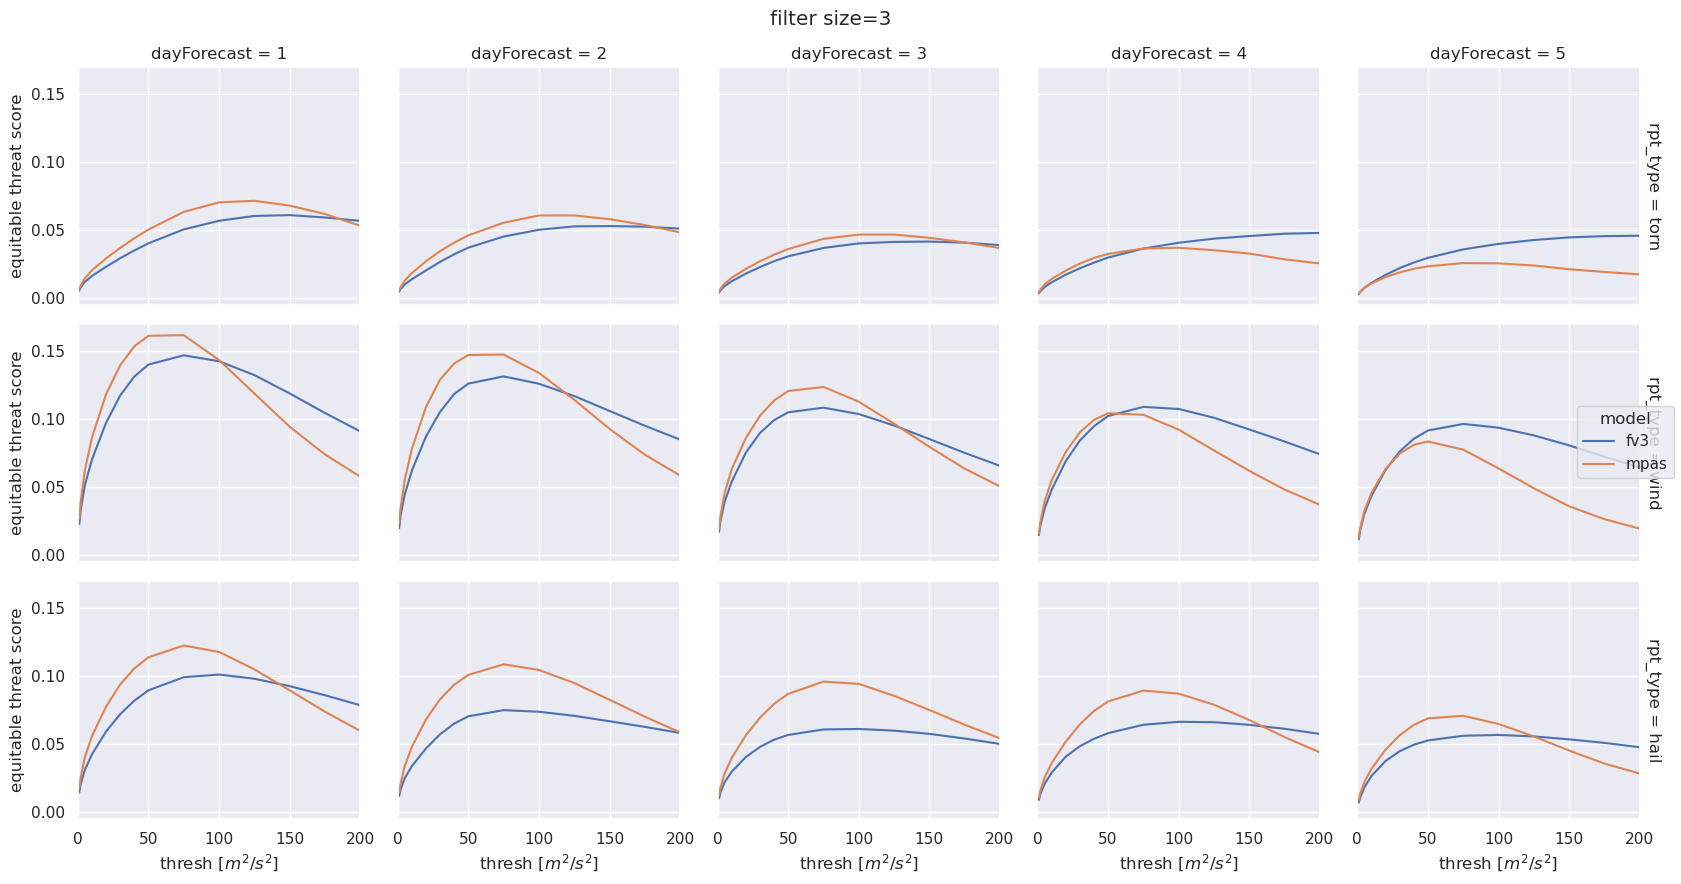

In [7]:
s = ets(contingency_table)
g = s.sel(variable=2).plot(col="dayForecast", row="rpt_type", hue="model", xlim=(0, 200))
g.fig.suptitle(f"filter size={filter_size}")
g.fig.tight_layout()

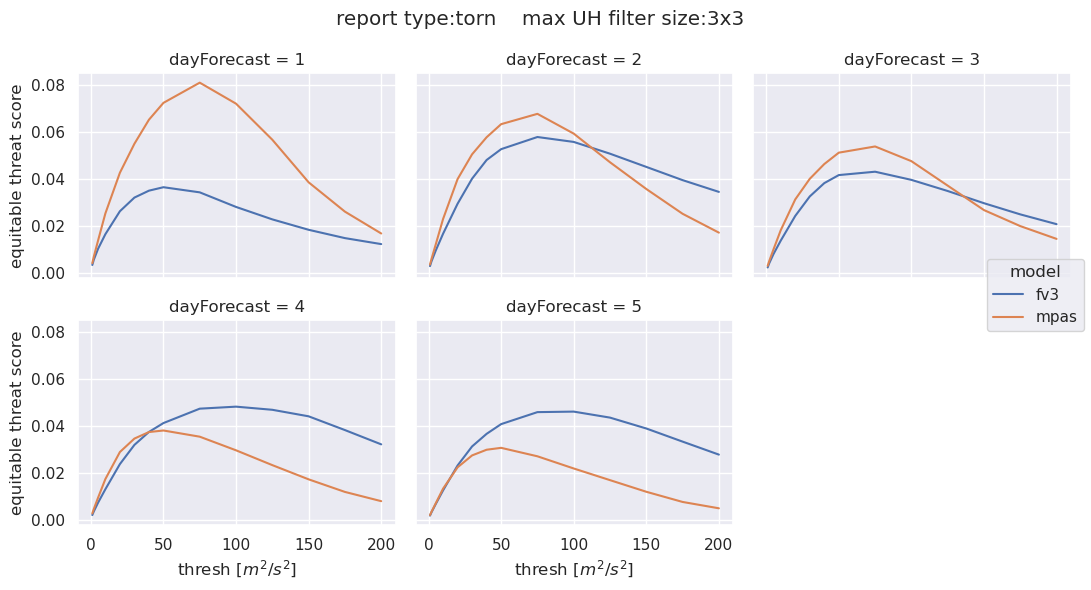

In [8]:
rpt_type = "torn"
s = ets(contingency_table)
g = s.sel(variable=1, rpt_type=rpt_type).plot(col="dayForecast", hue="model", col_wrap=3)
g.fig.suptitle(f"report type:{rpt_type}    max UH filter size:{filter_size}x{filter_size}")
g.fig.tight_layout()

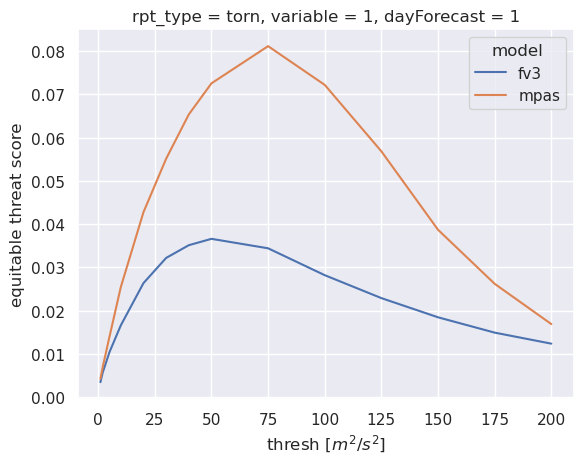

In [9]:
rpt_type = "torn"
s = ets(contingency_table)
g = s.sel(variable=1, dayForecast=1, rpt_type=rpt_type).plot(hue="model")

In [10]:
def calculate_bias(contingency_table):
    bias = (
        contingency_table.sel(count="hits") + contingency_table.sel(count="false alarms")
    ) / (contingency_table.sel(count="hits") + contingency_table.sel(count="misses"))
    return bias

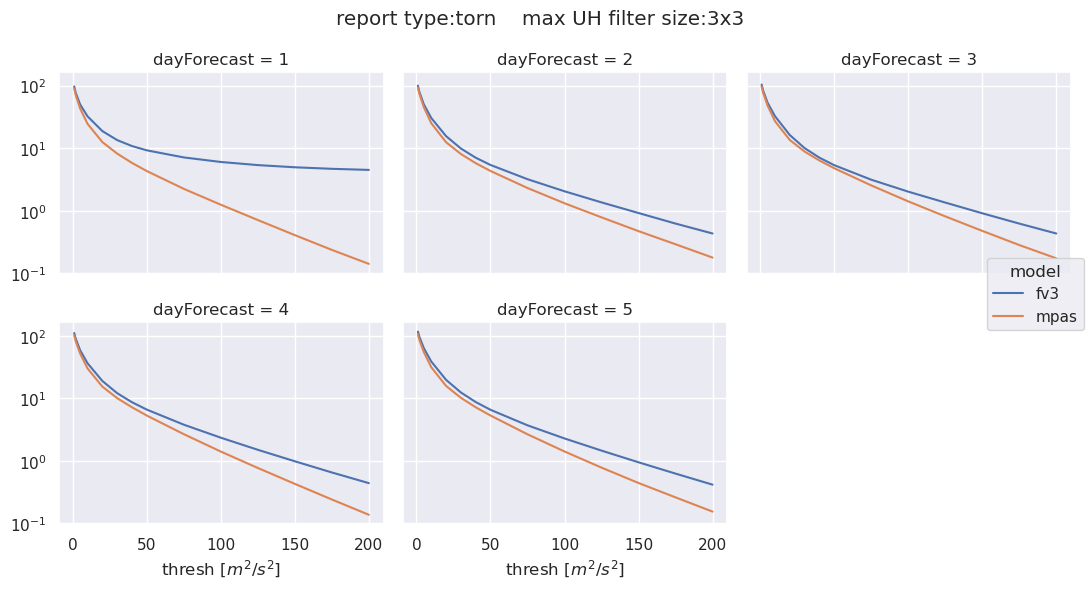

In [11]:
rpt_type = "torn"
s = calculate_bias(contingency_table)
g = s.sel(variable=1, rpt_type=rpt_type).plot(
    col="dayForecast", hue="model", col_wrap=3, yscale="log"
)
g.fig.suptitle(f"report type:{rpt_type}    max UH filter size:{filter_size}x{filter_size}")
g.fig.tight_layout()

In [12]:
def calculate_far(contingency_table):
    far = (contingency_table.sel(count="false alarms")) / (
        contingency_table.sel(count="hits") + contingency_table.sel(count="false alarms")
    )
    far.name = "false alarm ratio"
    return far

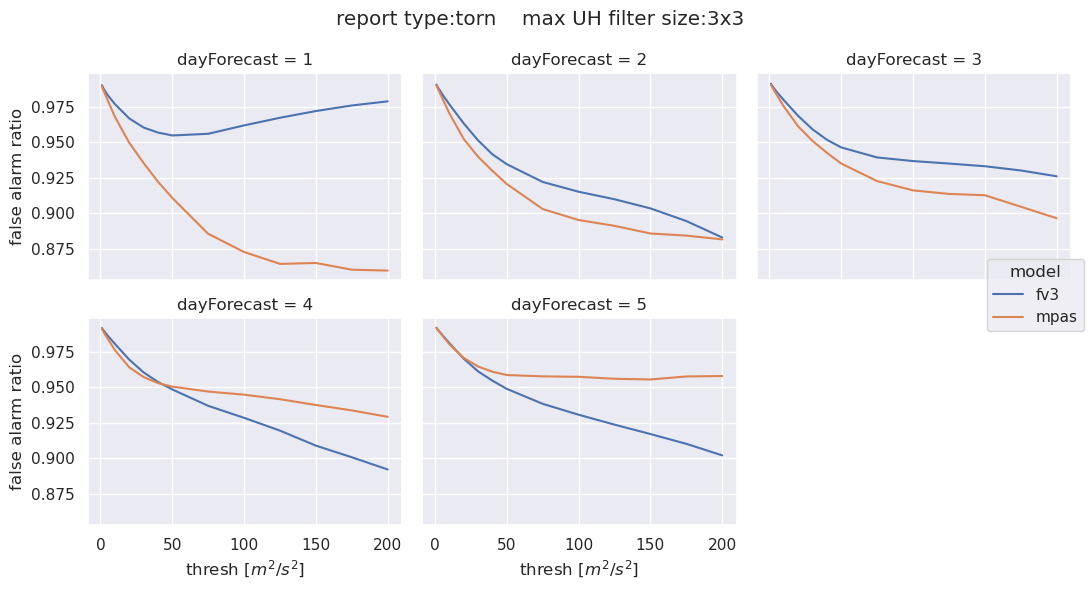

In [13]:
rpt_type = "torn"
s = calculate_far(contingency_table)
g = s.sel(variable=1, rpt_type=rpt_type).plot(
    col="dayForecast", hue="model", col_wrap=3
)
g.fig.suptitle(f"report type:{rpt_type}    max UH filter size:{filter_size}x{filter_size}")
g.fig.tight_layout()